In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.inspection import ImportanceData, MapInterface, dotplot

In [2]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), 7, [0,-1,-3,-5,-7,-11,-15,-21,-31])
#perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), [0,1,3,5,7,11,15,21,31], -3)
perm.load_data()
perm.scale_within(fill_na = True)
perm.reduce_over('fold', how = 'mean')
perm.reduce_over('clustid', how = 'max')

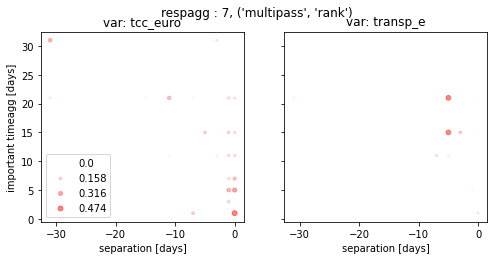

In [8]:
fig, axes = dotplot(perm.df.iloc[:,2], custom_order=['tcc_europe','transp_europe'], alphascaler = 1, nlegend_items=4)

In [4]:
shap = ImportanceData(basepath = Path('/scistor/ivm/jsn295/shaptest_standard'), respagg = 7, separation = [0,-1,-3,-5,-7,-11,-15,-21,-31])
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
shap.global_shap()
shap.reduce_over('clustid', how = 'max')

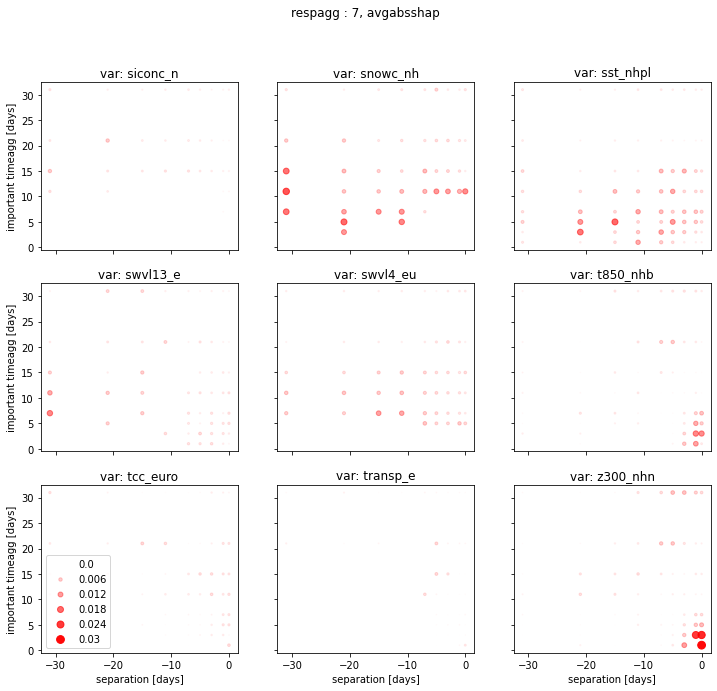

In [7]:
fig, axes = dotplot(shap.df.iloc[:,0], alphascaler = 32, sizescaler=2000, nlegend_items=6)

In [2]:
mapint = MapInterface(corclustpath=Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/'))

In [3]:
mapint.load_one_dataset('z300_nhnorm',7)


In [5]:
mapint.load_one_dataset('z300_nhnorm',11)

In [18]:
%timeit ds1.merge(ds2)

596 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


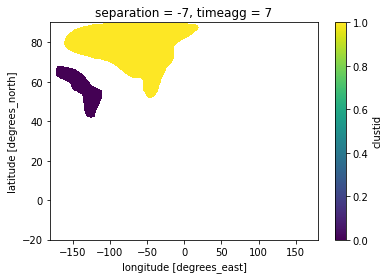

In [11]:
mapint.z300_nhnorm.clustid[0,-5,:,:].plot()

In [28]:
ds1.coords['separation'].values.astype(int)

array([-31, -21, -15, -11,  -7,  -5,  -3,  -1,   0])